In [2]:
import pandas
import time
import sys
sys.path.append('.')
import RM_exact
import RM_approx
import RM_helper
import RM_ADP

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D


--- 0.13008499145507812 seconds ---


In [ ]:
def compare_single_static(products, demands, cap_lb, cap_ub, cap_interval):
    """Compare the exact DP model with a heuristic, EMSR-b, for static models of single-resource RM problems."""
    col_titles = ['DP-rev', 'DP-protect', 'DP-time', 'EMSR-b-rev', 'EMSR-b-protect', 'EMSR-b-time','%Sum.Opt']
    capacities = [c for c in range(cap_lb, cap_ub + 1, cap_interval)]
    n_products = len(products)
    
    result = []
    for cap in capacities:
        dp_model = RM_exact.Single_RM_static(products, demands, cap)
        dp_time = time.time()
        dp_result = dp_model.value_func()
        dp_time = time.time() - dp_time
        
        approx_model = RM_approx.Single_EMSR(products, demands, cap)
        approx_time = time.time()
        approx_result = approx_model.value_func()
        approx_time = time.time() - approx_time
        
        dp_rev = dp_result[0][n_products - 1][cap]
        approx_rev = approx_result[0][n_products-1][cap]
        
        sub_optimal = (dp_rev - approx_rev) / dp_rev * 100
        result.append([round(dp_rev, 2), dp_result[1], round(dp_time, 2), round(approx_rev, 2), approx_result[1], \
                       round(approx_time, 2), "{0:.3f}%".format(sub_optimal)])
    
    print(pandas.DataFrame(result, capacities, col_titles))
    return result

# Examples, ref: example 2.3, 2.4 in "The Theory and Practice of Revenue Management"
products = [[1, 1050], [2,567], [3, 534], [4,520]]
# products=[[1, 1050], [2,950], [3, 699], [4,520]]
demands = [(17.3, 5.8), (45.1, 15.0), (39.6, 13.2), (34.0, 11.3)]
lb = 80
ub = 220
intervals = 15
result = compare_single_static(products, demands, lb, ub, 10)
x = np.linspace(lb, ub, intervals)
y1 = [r[0] for r in result]
y2 = [r[3] for r in result]

plt.clf()

line1, = plt.plot(x,y1, marker='^', label='DP Model')
line2, = plt.plot(x,y2, marker='o', label='EMSR-b')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1)})
plt.ylabel('Expected Revenue')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('Single-revs')

plt.clf()
y_diff = [float(r[6].strip('%')) for r in result]
plt.ylabel('Revenue Difference (%)')
plt.xlabel('Resource Capacity')
plt.plot(x, y_diff, 'ro-')

# plt.show()
plt.savefig('Single-Diff')


In [ ]:
plt.clf()
DP_time = [r[2] for r in result]
approx_time = [r[5] for r in result]
line3, = plt.plot(x,DP_time, marker='^', label='DP Model')
line4, = plt.plot(x,approx_time, marker='o', label='EMSR-b')
plt.legend(handler_map={line3: HandlerLine2D(numpoints=1),line4: HandlerLine2D(numpoints=1)})
plt.ylabel('Running Time(s)')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('Single-times')

In [ ]:
def compare_iDAVN_singleDPstatic(products, resources, n_class, cap_lb, cap_ub, cap_interval):
    """Compare the iterative DAVN method, with a collection of single-resource static DP model."""
    n_resources = len(resources)
    col_titles = ['DAVN:bid-p', 'DAVN:rev', 'DAVN:time']
    capacities = [c for c in range(cap_lb, cap_ub + 1, cap_interval)]
    for i in range(n_resources):
            resource_name = resources[i]
            col_titles.append('S-S: rev-' + resource_name)
    
    col_titles.append("S-S: sum")
    col_titles.append("S-S:total time")
    
    table_data = []
    (pros, demands, demands_with_names) = RM_helper.sort_product_demands(products)
    for cap in capacities:
        result= []
        caps = [cap] * n_resources
        
        DAVN_time = time.time()
        DAVN_bid_prices, DAVN_total_rev = RM_approx.iterative_DAVN(pros, resources, demands_with_names, n_class,\
                                                                   caps, caps)
        DAVN_time = time.time() - DAVN_time

        result.append(DAVN_bid_prices)
        result.append(DAVN_total_rev)
        result.append(DAVN_time)

        single_static_vf = []
        single_total_time =0
        for i in range(n_resources):
            resource_name = resources[i]
            products_i = [j for j in products if resource_name in j[0]]
            ps, ds, _ = RM_helper.sort_product_demands(products_i)
            
            single_time = time.time()
            problem = RM_exact.Single_RM_static(ps, ds, cap)
            vf_i = problem.value_func()
            single_time = time.time() - single_time
            single_total_time += single_time
            
            single_static_vf.append(vf_i[0][-1][-1])
            result.append(vf_i[0][-1][-1])
        result.append(sum(single_static_vf))
        result.append(single_total_time)
        
        table_data.append(result)
    
    print(pandas.DataFrame(table_data, capacities, col_titles))
    return table_data


# Compare
products = [['1a', (17.3, 5.8), 1050], ['2a', (45.1, 15.0),950], ['3a', (39.6, 13.2), 699], ['4a', (34.0, 11.3),520],\
            ['1b', (20, 3.5), 501], ['2b', (63.1, 2.5), 352], ['3b', (22.5, 6.1), 722], ['1ab', (11.5, 2.1), 760],\
            ['2ab', (24.3, 6.4), 1400]]
resources = ['a', 'b']
# compare_iDAVN_singleDPstatic(products,resources, 6, 80, 120, 10)
lb = 60
# ub = 160
ub = 70
data = compare_iDAVN_singleDPstatic(products, resources, 4, lb, ub, 10)

revs_DAVN = [d[1] for d in data]
revs_singleDP = [d[5] for d in data]
revs_diff_perc = [(d[1]-d[5]) / d[1] * 100 for d in data]
time_DAVN = [d[2] for d in data]
time_singleDP = [d[6] for d in data]

plt.clf()
x= np.linspace(lb, ub, (ub - lb) / 10 + 1)
line1, = plt.plot(x,revs_DAVN, marker='^', label='DAVN')
line2, = plt.plot(x,revs_singleDP, marker='o', label='Single_Static_DP')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1)})
plt.ylabel('Expected Revenue')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('DAVN-ssDP-revs')

plt.clf()
line3, = plt.plot(x,time_DAVN, marker='^', label='DAVN')
line4, = plt.plot(x,time_singleDP, marker='o', label='Single_Static_DP')

plt.legend(handler_map={line3: HandlerLine2D(numpoints=1),line4: HandlerLine2D(numpoints=1)})
plt.ylabel('Running Time(s)')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('DAVN-ssDP-time')
plt.clf()
plt.plot(x, revs_diff_perc, 'bo-')
plt.ylabel('Revenue Difference(%)')
plt.xlabel('Resource Capacity')
plt.savefig('DAVN-ssDP-diff')

In [ ]:
# Draw the graph of running time of the network_DP model
def eval_networkDP_changingCap(products, resources, cap_lb, cap_ub, total_time):
    """Evaluate the network DP method, trying with different capacities of resource, and different total time."""
    n_resources = len(resources)
    col_titles = ['Revenue', 'Bid Prices', 'Time']
    capacities = [c for c in range(cap_lb, cap_ub + 1)]
    
    table = []
    (pros, demands, demands_with_names) = RM_helper.sort_product_demands(products)
    for cap in capacities:
        caps = [cap] * n_resources
        
        result= []
        
        DP_time = time.time()
        problem = RM_exact.Network_RM(pros, resources, [demands], caps, total_time)
        DP_vf = problem.value_func()
        bid_prices = problem.bid_price(total_time, caps)
        DP_time = time.time() - DP_time

        result.append(DP_vf[0][-1])
        result.append(bid_prices)
        result.append(DP_time)
        
        table.append(result)
        
    print(pandas.DataFrame(table, capacities, col_titles))
    return table
        

ps1 = [['a1', 0.02, 200], ['a2', 0.06, 503], ['ab1', 0.08, 400],['ab2', 0.01, 704], ['b1', 0.05, 601], ['b2', 0.12, 106],\
            ['bc', 0.03, 920],['c1', 0.07, 832],['d1', 0.14, 397], ['d2',  0.18, 533], ['ad', 0.09, 935], \
      ['ae', 0.013, 205],['f3', 0.004, 589], ['fb', 0.009, 422]]
rs1 = ['a', 'b', 'c', 'd', 'e', 'f']

ps2 = [['a1', 0.02, 200], ['a2', 0.06, 503], ['ab1', 0.08, 400],['ab2', 0.01, 704], ['b1', 0.05, 601], \
      ['b2', 0.12, 106], ['bc', 0.03, 920],['c1', 0.07, 832]]
rs2 = ['a', 'b', 'c']

cap_ub = 8
T = 5
table1 = eval_networkDP_changingCap(ps1, rs1, 1, cap_ub,T)
table2 = eval_networkDP_changingCap(ps1, rs1, 1, cap_ub, 2*T)
table3 = eval_networkDP_changingCap(ps1, rs1, 1, cap_ub, 3*T)

x= np.linspace(1, cap_ub, cap_ub)
revs1 = [d[0] for d in table1]
time1 = [d[2] for d in table1]
revs2 = [d[0] for d in table2]
time2 = [d[2] for d in table2]
revs3 = [d[0] for d in table3]
time3 = [d[2] for d in table3]

plt.clf()
line1, = plt.plot(x,revs1, marker='^', label='max_time='+str(T))
line2, = plt.plot(x,revs2, marker='o', label='max_time='+str(T))
line3, = plt.plot(x,revs3, marker='x', label='max_time='+str(T))
# line2, = plt.plot(x,revs_singleDP, marker='o', label='Single_Static_DP')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1),line3: HandlerLine2D(numpoints=1)})
# legend = ax.legend(loc='upper center')
plt.ylabel('Expected Revenue')
plt.xlabel('Resource Capacity')
plt.show()
plt.savefig('network-DP-revs-6')

plt.clf()
line1, = plt.plot(x,time1, marker='^', label='max_time='+str(T))
line2, = plt.plot(x,time2, marker='o', label='max_time='+str(T))
line3, = plt.plot(x,time3, marker='x', label='max_time='+str(T))

plt.legend(handler_map={line1: HandlerLine2D(numpoints=1),line2: HandlerLine2D(numpoints=1),line3: HandlerLine2D(numpoints=1)})
plt.ylabel('Running Time(s)')
plt.xlabel('Resource Capacity')
# plt.show()
plt.savefig('network-DP-time-6')


In [9]:
def evaluate_network_control(products, resources, demands, capacities, approxed_bid_prices, total_time, iterations):
    """using the given bid-prices of a heuristic/approximation to evaluate the difference between revenues gained 
    between that heuristic/approximation with optimal method, i.e. network-DP model"""
    incidence_matrix = RM_helper.calc_incidence_matrix(products, resources)
    
    diff_percents = []
    
    exact_method = RM_exact.Network_RM(products, resources, [demands], capacities, total_time)
    exact_method.value_func()
    exact_bid_prices = exact_method.bid_prices()
    
    for round in range(iterations):
        requests = RM_helper.sample_network_demands(demands, total_time)

        rev_exact = 0 # records the total revenue using the optimal control
        curr_cap_exact = capacities[:]
        rev_heuri = 0 # records the total revenue using the control produced by heuristic/approximation
        curr_cap_heuri = capacities[:]

        total_states = 1
        for c in capacities:
                total_states *= (c+1)

        for t in range(total_time):
            prod_requested = requests[t]
            if prod_requested < len(products):
                # a request arrives
                incidence_vector = [row[prod_requested] for row in incidence_matrix]
                state_index_exact = RM_helper.state_index(total_states, capacities, curr_cap_exact)
                state_index_heuri = RM_helper.state_index(total_states, capacities, curr_cap_heuri)
                
                rev = products[prod_requested][1]
                if decide_to_sell(incidence_vector, curr_cap_exact, exact_bid_prices, rev, t, state_index_exact):
                    curr_cap_exact = [c_i - x_i for c_i, x_i in zip(curr_cap_exact, incidence_vector)]
                    rev_exact += rev
                if decide_to_sell(incidence_vector, curr_cap_heuri, approxed_bid_prices, rev, t, state_index_heuri):
                    curr_cap_heuri = [c_i - x_i for c_i, x_i in zip(curr_cap_heuri, incidence_vector)]
                    rev_heuri += rev
#         print("exact rev=", rev_exact, ", heuristic rev=", rev_heuri)
        if rev_exact >= rev_heuri:
            diff = rev_exact - rev_heuri
            diff_percent = (diff / rev_exact) * 100
            diff_percents.append(diff_percent)
    
    avrg_diff_percent = np.mean(diff_percents)
    return avrg_diff_percent
            
def decide_to_sell(incidence_vector, remained_cap, resource_bid_prices, profit, t, s):
    """deicide at time t, state s, whether to sell the product according to its profit"""
    if t < len(resource_bid_prices) - 1:
        bid_prices = resource_bid_prices[t+1][s]
        opportunity_cost = np.dot(incidence_vector, bid_prices)
    else:
        opportunity_cost = 0
    return all(x_i <= c_i for x_i, c_i in zip(incidence_vector, remained_cap)) and profit >= opportunity_cost

    diff-T=10  diff-T=20  mean_diff
2    8.407433  14.444674  11.426054
10   4.801288   8.541920   6.671604
18  12.955531   3.692338   8.323935


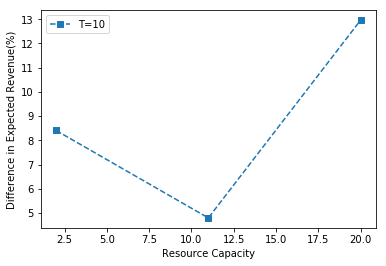

In [10]:
def eval_ADP_DPf(pros, resources, capacities, total_time, iterations):
    """Compare the ADP algorithm using DP model with feature extraction, with exact DP model of network problems."""
    products, demands,_ = RM_helper.sort_product_demands(pros)
    problem = RM_ADP.DP_w_featureExtraction(products, resources, [demands], capacities, total_time)
    problem.value_func("")
    bid_prices = problem.bid_prices()
    diff_percent = evaluate_network_control(products, resources, demands, capacities, bid_prices, total_time, \
                                            iterations)
    return diff_percent

def visualize_perf_ADP_DPf(products, resources, T_lb, T_ub, T_interval, cap_lb, cap_ub, cap_interval, iterations):
    """Visualize the performance of ADP_DPf method, against network_DP model."""
    n_resources = len(resources)
    Ts = [T for T in range(T_lb, T_ub + 1, T_interval)]
    col_titles = [('diff-T='+str(T)) for T in Ts]
    col_titles.append('mean_diff')
    
    capacities = [c for c in range(cap_lb, cap_ub + 1, cap_interval)]
    table_data = []
    
    for cap in capacities:
        caps = [cap] * n_resources
        result= []
        for T in Ts:
            result.append(eval_ADP_DPf(products, resources, caps, T, iterations))
        
        result.append(np.mean(result))
        table_data.append(result)
    
    print(pandas.DataFrame(table_data, capacities, col_titles))
    return table_data

ps = [['a1', 0.22, 200], ['a2', 0.06, 503], ['ab1', 0.18, 400],['ab2', 0.1, 704], ['b1', 0.05, 601], \
      ['b2', 0.12, 106], ['bc', 0.13, 920],['c1', 0.07, 832]]
resources = ['a', 'b', 'c']

T_lb = 10
T_ub = 20
T_interval = 10
cap_lb = 2
cap_ub = 20
cap_interval = 8 
iterations = 20
data = visualize_perf_ADP_DPf(ps, resources, T_lb, T_ub, T_interval, cap_lb, cap_ub, cap_interval, iterations)

plt.clf()
x= np.linspace(cap_lb, cap_ub, (cap_ub - cap_lb) / cap_interval + 1)
for i in range(1):
    T = T_lb + T_interval * i
    rev_diff = [d[i] for d in data]
    plt.plot(x, rev_diff, linestyle='dashed', marker='s', label="T="+str(T))
    
plt.legend()
plt.ylabel('Difference in Expected Revenue(%)')
plt.xlabel('Resource Capacity')
plt.show()
plt.savefig('ADP_DPf_networkDP-rev-diff')

In [22]:
def eval_single_static_by_bid_prices(products, requests, bid_prices, capacity):
    """ Use sampled requests of products, to calculate the expected revenue using the given bid-prices. """
    """ note that input of requests are in descending order of products' prices. """
    n_products = len(products)
    total_rev = 0
    remain_cap = capacity
    for fare_class in range(n_products - 1, 0, -1):
        price = products[fare_class][1]
        bid_price = bid_prices[fare_class - 1]
        if price >= bid_price[remain_cap]:
            # only sell product of current fare class if its profit exceeds the bid price of current class
            for z in range(min(requests[fare_class], remain_cap), -1, -1):
                if price >= bid_price[remain_cap - z]:
#                     print("in bidPrice: reque = ", requests[fare_class], ", price=", price, " bid_price=", bid_price[remain_cap - z], " decision=",z)
                    remain_cap -= z
                    total_rev += price * z
                    break
    # for the highest fare class, accept all requests
    request = requests[0]
    z = min(request, remain_cap)
    remain_cap -= z
    total_rev += products[0][1] * z
    
    return (total_rev, remain_cap)

def eval_single_static_by_protection_levels(products, requests, protection_levels, capacity):
    """ Use sampled requests of products, to calculate the expected revenue using the given protection-levels. """
    """ note that input of requests are in descending order of products' prices. """
#     print("protection-levles = ", protection_levels)
    n_products = len(products)
    total_rev = 0
    remain_cap = capacity
    for fare_class in range(n_products - 1, -1, -1):
        price = products[fare_class][1]
        if fare_class > 0:
            protection_l = protection_levels[fare_class - 1]
        else:
            protection_l = 0
        request = requests[fare_class]
        decision = int(min(max(0, remain_cap - protection_l), request))
#         print("in protL: request = ", request, ", protect-l = ", protection_l, "deicision = ", decision)
        remain_cap -= decision
        total_rev += decision * price
    return (total_rev, remain_cap)

In [1]:
def compare_EMSR_b_with_exact(pros, cap, iterations):
    """Compare the EMSR-b method, with single-static DP model."""
    products, demands,_ = RM_helper.sort_product_demands(pros)
    
    diff_percents = []
    
    exact = RM_exact.Single_RM_static(products, demands, cap)
    exact_bid_prices = exact.get_bid_prices()
    exact_protection_levels = exact.get_protection_levels()
    
    heuri = RM_approx.Single_EMSR(products, demands, cap)
    heuri_protection_levels = heuri.get_protection_levels()

    for i in range(iterations):
        requests = RM_helper.sample_single_static_demands(demands)
#         print("requests = ", requests)
        exact_rev_bp = eval_single_static_by_bid_prices(products, requests, exact_bid_prices, cap)[0]
        exact_rev_pl = eval_single_static_by_protection_levels(products, requests, exact_protection_levels, cap)[0]

        heuri_rev_pl = eval_single_static_by_protection_levels(products, requests, heuri_protection_levels, cap)[0]

#         print("exact: bid-price: ", exact_rev_bid_prices, ", protect-l:", exact_rev_prot_levels, "heuri: ", heuri_rev_prot_levels)
        diff_bid_prices = (exact_rev_bp - heuri_rev_pl) / exact_rev_bp * 100
        diff_protection_levels = (exact_rev_pl - heuri_rev_pl) / exact_rev_pl * 100
        
        diff_percents.append([exact_rev_bp, exact_rev_pl, heuri_rev_pl, diff_bid_prices, diff_protection_levels])
    return np.mean(diff_percents, 0)


def visualize_perf_EMSR_b(products, cap_lb, cap_ub, cap_interval, iterations):
    """Visualize the performance of EMSR-b method, against single-static DP model."""
    capacities = [c for c in range(cap_lb, cap_ub + 1, cap_interval)]
    col_titles = ["exact-bid_prices", "exact-protection_levels", "EMSR-b-protection_levels", "mean-diff_bp %", \
                  "mean-diff_pl %"]
    
    table_data = []
    
    for cap in capacities:
        result= compare_EMSR_b_with_exact(products, cap, iterations)
        
        table_data.append(result)
    
    print(pandas.DataFrame(table_data, capacities, col_titles))
    return table_data

# pros = [[1,(17.3, 5.8), 1050], [2, (45.1, 15.0), 567], [3, (39.6, 13.2), 534], [4,(34.0, 11.3),520]]
pros = [[1,(17.3, 5.8), 1050], [2, (45.1, 15.0), 950], [3, (39.6, 13.2), 699], [4,(34.0, 11.3),520]]
cap_lb = 80
cap_ub = 160
cap_interval = 10
iteration = 100

# data = visualize_perf_EMSR_b(pros, cap_lb, cap_ub,cap_interval,iteration)
# y = [d[3] for d in data]
# y2 = [d[4] for d in data]

# plt.clf()
# x= np.linspace(cap_lb, cap_ub, (cap_ub - cap_lb) / cap_interval + 1)
# plt.plot(x, y, linestyle='dashed', marker='s', label='by bid-prices')
# plt.plot(x, y2, linestyle='dashed', marker = 'o', label='by protection-levels')
    
# plt.legend()
# plt.ylabel('Difference in Expected Revenue(%)')
# plt.xlabel('Resource Capacity')
# plt.show()
# plt.savefig('single_static_revs_diff')

In [36]:
def simulate_single_static_bidprices_control(bid_prices, products, demands, capacity):
    """Simulates bid-price control over the horizon T, on a single-static problem, with initial capacity given. 
    ----------------------------
    Inputs:
        bid_prices: bid prices of methods to be simulated
        products: i.e. itineraries, assumed to be sorted in descending order of revenus, in the form of 
                (name, revenue)
        demands: mean and std of demand distribution for products, in the same order as the products are given
        capacity: initial capacity of the resource
    Returns: total revenue and load factor of each method. """
    
    n_methods = len(bid_prices)
    requests = RM_helper.sample_single_static_demands(demands)
    revs = [0] * n_methods # records the total revenue using bid prices produced by the two methods, i.e. bid_prices
    curr_cap = [capacity] * n_methods

    n_products = len(products)
    for m in range(n_methods):
        for fare_class in range(n_products - 1, 0, -1):
            price = products[fare_class][1]
            bid_price_j = bid_prices[m][fare_class - 1]
            remain_cap = curr_cap[m]
            if price >= bid_price_j[remain_cap]:
                # only sell product of current fare class if its profit exceeds the bid price of current class
                for z in range(min(requests[fare_class], remain_cap), -1, -1):
                    if price >= bid_price_j[remain_cap - z]:
                        curr_cap[m] -= z
                        revs[m] += price * z
                        break
        # for the highest fare class, accept all requests
        request = requests[0]
        z = min(request, remain_cap)
        curr_cap[m] -= z
        revs[m] += products[0][1] * z
    
    result = [(revs[m], round(curr_cap[m] / capacity * 100,3)) for m in range(n_methods)]
    return result

pros = [[1,(17.3, 5.8), 1050], [2, (45.1, 15.0), 950], [3, (39.6, 13.2), 699], [4,(34.0, 11.3),520]]
cap = 80
# products, demands, _ = RM_helper.sort_product_demands(pros)
# exact = RM_exact.Single_RM_static(products, demands, cap)
# exact_bid_prices = exact.get_bid_prices()
# simulate_single_static_bidprices_control([exact_bid_prices], products, demands, cap)


In [37]:
def simulate_network_bidprices_control(bid_prices, products, arrival_rates, capacities, T):
    """Simulates bid-price control over the horizon T, on a network problems, with initial capacity given. 
    ----------------------------
    Inputs:
        bid_prices: bid prices of methods to be simulated
        products: i.e. itineraries, assumed to be sorted in descending order of revenus, in the form of 
                (name, revenue)
        arrival_rate: arrival rates of demands, in the same order as the products are given
        capacities: initial capacities of resources
        T: total time, i.e. sales horizon
    Returns: total revenue and load factor of each method. """
    
    n_methods = len(bid_prices)
    incidence_matrix = RM_helper.calc_incidence_matrix(products, resources)
    requests = RM_helper.sample_network_demands(arrival_rates, T)
    revs = [0] * n_methods # records the total revenue using bid prices produced by the two methods, i.e. bid_prices
    curr_caps = [capacities[:]] * n_methods

    total_states = 1
    for c in capacities:
        total_states *= (c+1)

    for t in range(T):
        prod_requested = requests[t]
        if prod_requested < len(products):
            # a request arrives
            incidence_vector = [row[prod_requested] for row in incidence_matrix]
            state_index = [RM_helper.state_index(total_states, capacities, curr_caps[i]) for i in range(n_methods)]

            profit = products[prod_requested][1]
            for i in range(n_methods):
                if t < (T - 1): 
                    bp_t = bid_prices[i][t+1][state_index[i]]
                    opportunity_cost = np.dot(incidence_vector, bp_t)
                else:
                    opportunity_cost = 0
                    
                remain_cap = [c_i - x_i for c_i, x_i in zip(curr_caps[i], incidence_vector)]
                
                if profit >= opportunity_cost and all(c_i >= 0 for c_i in remain_cap):
                    # decides to sell the product
                    revs[i] += profit
                    curr_caps[i] = remain_cap[:]
                    
    result = [(revs[i], round(sum(curr_caps[i]) / sum(capacities) * 100, 3)) for i in range(n_methods)]
    return result

ps = [['a1', 200, 0.22], ['a2', 503, 0.06], ['ab1', 400, 0.18],['ab2', 704, 0.1], ['b1', 601, 0.05], \
      ['b2', 106, 0.12], ['bc', 920, 0.13],['c1', 832, 0.07]]
resources = ['a', 'b', 'c']
capacities = [3,3,3]
total_time = 10
# products, arrival_rates,_ = RM_helper.sort_product_demands_NEW(ps)
# demands = [(a * total_time, 0) for a in arrival_rates]
# problem = RM_ADP.ALP(products, resources, [demands], capacities, total_time,arrival_rates)
# bid_prices = problem.get_bid_prices(10)
# exact_method = RM_exact.Network_RM(products, resources, [arrival_rates], capacities, total_time)
# exact_method.value_func()
# exact_bid_prices = exact_method.bid_prices()

# simulate_network_bidprices_control([bid_prices, exact_bid_prices], products, arrival_rates, capacities, total_time)